# LSTM模型实现IMDB影评情感识别




1. **下载并解压 IMDB 数据集**（包含25,000条训练评论和25,000条测试评论）。
2. **数据预处理**：清洗文本（去除 HTML 标签、标点符号等）、转小写，并进行分词（tokenization），准备训练集和测试集。
3. **构建词汇表和序列**：基于训练集单词构建词汇表，设置最大序列长度，将影评文本转换为固定长度的数字序列（索引序列），并进行填充（padding）。
4. **词向量嵌入**：使用词嵌入层将单词索引映射为稠密向量（可以选择使用预训练的 GloVe 向量，或随机初始化嵌入并在训练中学习）。
5. **构建 LSTM 分类模型**：包括嵌入层、LSTM层（支持单向或双向）、线性输出层组成的模型。
6. **训练模型**：包括 loss 计算（如 BCEWithLogitsLoss）、优化器（如 Adam）、训练可视化（loss/accuracy 曲线）。
7. **模型评估**：在测试集上输出准确率。
8. **模型保存与加载**：演示如何保存训练好的模型参数，并加载模型用于后续使用。


接下来，我们将按照上述步骤逐步实现。


## 1. 数据集下载和解压

首先下载 IMDB 影评情感分析数据集并解压。数据集由斯坦福提供，包含50000条电影评论，其中25000条用于训练，25000条用于测试，评论分别标注为**positive**（正面）或**negative**（负面)。


In [1]:
import urllib.request
import tarfile
import os

# 下载 IMDB 数据集压缩包
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
filename = "aclImdb_v1.tar.gz"
if not os.path.exists(filename):
    print("Downloading dataset...")
    urllib.request.urlretrieve(url, filename)
    print("Download complete.")
else:
    print("Dataset archive already exists.")

# 解压缩 .tar.gz 文件
if not os.path.exists("aclImdb"):
    print("Extracting dataset files...")
    with tarfile.open(filename, "r:gz") as tar:
        tar.extractall()  # 解压出 aclImdb/ 目录
    print("Extraction complete.")
else:
    print("Dataset directory already exists.")

# 列出训练集和测试集目录内容
train_dir = "aclImdb/train"
test_dir = "aclImdb/test"
print("Train subfolders:", os.listdir(train_dir))
print("Test subfolders:", os.listdir(test_dir))
print("Number of training pos files:", len(os.listdir(os.path.join(train_dir, "pos"))))
print("Number of training neg files:", len(os.listdir(os.path.join(train_dir, "neg"))))
print("Number of test pos files:", len(os.listdir(os.path.join(test_dir, "pos"))))
print("Number of test neg files:", len(os.listdir(os.path.join(test_dir, "neg"))))


Dataset archive already exists.
Extracting dataset files...


/tmp/ipykernel_7378/3214773248.py:19: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()  # 解压出 aclImdb/ 目录


Extraction complete.
Train subfolders: ['neg', 'urls_neg.txt', 'unsup', 'pos', 'urls_pos.txt', 'urls_unsup.txt', 'unsupBow.feat', 'labeledBow.feat']
Test subfolders: ['neg', 'urls_neg.txt', 'pos', 'urls_pos.txt', 'labeledBow.feat']
Number of training pos files: 12500
Number of training neg files: 12500
Number of test pos files: 12500
Number of test neg files: 12500


运行上述代码后，看到输出下载/解压完成，以及训练集正面、负面评论各12500条，测试集正面、负面评论各12500条

## 2. 数据预处理（清洗文本 & 分词）

原始的 IMDB 评论文本包含一些**HTML 标签**（例如 `<br />` 用于换行）以及各种标点符号、大小写混杂等。为了简化模型的学习，我们需要对文本进行清洗和标准化：

- **去除 HTML 标签**：如 `<br />` 等。
- **移除标点符号**：将标点用空格替换或删除，仅保留字母和数字（以便后续分词）。
- **转换为小写**：将所有字母转成小写，保证一致性。

完成清洗后，我们再对评论进行**分词**（Tokenization），也就是将句子拆分为单词序列。简单起见，我们可以按空格拆分单词。随后，我们会将处理后的文本划分为训练集和测试集对应的数据结构。


In [2]:
import re

def clean_text(text):
    """清洗文本：去除HTML标签和标点，并转换为小写。"""
    # 去掉 HTML 标签
    text = re.sub(r"<.*?>", "", text)
    # 去掉标点符号（只保留字母、数字和空格）
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    # 转换为小写
    text = text.lower()
    return text

# 测试清洗函数
sample_text = "I <br /> loved this Movie!!! It's great, though a bit long."
print("原始文本:", sample_text)
print("清洗后:", clean_text(sample_text))


原始文本: I <br /> loved this Movie!!! It's great, though a bit long.
清洗后: i  loved this movie its great though a bit long


接下来，我读取训练和测试集中的所有评论文件，应用清洗函数并进行分词。由于数据集已经按文件夹区分正负面，我们可以直接根据所在目录来赋予标签：`pos`目录下的评论标记为1（正面），`neg`目录下标记为0（负面）。


In [3]:
import os

# 准备容器
train_tokens = []   # 存储训练集每条评论的分词结果
train_labels = []   # 存储训练集每条评论的标签 (1或0)
test_tokens = []
test_labels = []

# 处理训练集
for label in ["pos", "neg"]:
    folder = os.path.join(train_dir, label)
    for filename in os.listdir(folder):
        # 读取评论文本
        with open(os.path.join(folder, filename), "r", encoding="utf-8") as f:
            text = f.read().strip()
        # 清洗 + 分词
        text = clean_text(text)
        tokens = text.split()  # 按空格分词
        # 保存结果
        train_tokens.append(tokens)
        train_labels.append(1 if label == "pos" else 0)

# 处理测试集
for label in ["pos", "neg"]:
    folder = os.path.join(test_dir, label)
    for filename in os.listdir(folder):
        with open(os.path.join(folder, filename), "r", encoding="utf-8") as f:
            text = f.read().strip()
        text = clean_text(text)
        tokens = text.split()
        test_tokens.append(tokens)
        test_labels.append(1 if label == "pos" else 0)

# 打乱训练集数据顺序（测试集无需打乱）
# 以防止所有正面评论和负面评论分别集中
import random
train_data = list(zip(train_tokens, train_labels))
random.shuffle(train_data)
train_tokens, train_labels = zip(*train_data)  # 打乱后拆分
train_tokens = list(train_tokens)
train_labels = list(train_labels)

# 简单检查处理结果
print("训练集评论数:", len(train_tokens))
print("测试集评论数:", len(test_tokens))
print("第1条训练评论分词结果:", train_tokens[0][:20], "...")  # 打印前20个词作为示例
print("对应标签:", train_labels[0])


训练集评论数: 25000
测试集评论数: 25000
第1条训练评论分词结果: ['german', 'filmmaker', 'ulli', 'lommel', 'has', 'managed', 'a', 'task', 'many', 'horror', 'fans', 'thought', 'was', 'impossible', 'hes', 'unseated', 'fellow', 'teuton', 'uwe', 'boll'] ...
对应标签: 0


## 3. 构建词汇表和词汇预处理

把word映射成索引

具体步骤：
- **统计词频**：计算训练集中所有单词的出现频率。
- **限定词汇大小**：设定一个最大词汇大小（这里设置为10000）以控制模型规模和过滤罕见词。对于不在词汇表中的词用特殊标记 `<UNK>` 表示。
- **建立映射**：将词汇表中每个单词分配一个索引。保留索引0给**填充符 `<PAD>`**，索引1给**未知词 `<UNK>`**，从索引2开始给频率高的单词分配索引。
- **文本序列数字化**：将每条评论的单词序列替换为对应的索引序列。
- **序列截断/填充**：由于不同评论的长度不同，需要统一序列长度。设定一个**最大序列长度**（例如500）。对于超过该长度的序列予以截断，只保留前面的部分；对于短于该长度的序列，用`<PAD>`（索引0）填充至固定长度。


In [4]:
from collections import Counter
import numpy as np

# 统计训练集词频
counter = Counter()
for tokens in train_tokens:
    counter.update(tokens)
print("训练集中的不同单词数（未经限制）:", len(counter))

# 限定词汇表大小
max_vocab_size = 10000  # 我们只保留最常见的10000个单词
most_common = counter.most_common(max_vocab_size)
print(f"词频最高的5个单词: {most_common[:5]}")

# 建立 单词->索引 映射
word2idx = {"<PAD>": 0, "<UNK>": 1}
for idx, (word, freq) in enumerate(most_common, start=2):
    word2idx[word] = idx
vocab_size = len(word2idx)
print("词汇表大小:", vocab_size)

# 将训练集和测试集的 token 序列转换为索引序列
train_sequences = []
for tokens in train_tokens:
    seq = [word2idx.get(word, 1) for word in tokens]  # 不在词表的词用<UNK>(索引1)替代
    train_sequences.append(seq)
test_sequences = []
for tokens in test_tokens:
    seq = [word2idx.get(word, 1) for word in tokens]
    test_sequences.append(seq)

# 设置最大序列长度并对序列进行填充/截断
MAX_LEN = 500  # 最大序列长度
def pad_or_truncate(seq, max_len):
    if len(seq) >= max_len:
        return seq[:max_len]    # 截断到最大长度
    else:
        return seq + [0] * (max_len - len(seq))  # 不足则填充0（<PAD>）

X_train_seq = [pad_or_truncate(seq, MAX_LEN) for seq in train_sequences]
X_test_seq  = [pad_or_truncate(seq, MAX_LEN) for seq in test_sequences]

# 转换为numpy数组以便构建张量
X_train_seq = np.array(X_train_seq)
X_test_seq = np.array(X_test_seq)
y_train = np.array(train_labels)
y_test = np.array(test_labels)

print("训练序列数组形状:", X_train_seq.shape)
print("测试序列数组形状:", X_test_seq.shape)
print("第一条训练序列 (索引形式):", X_train_seq[0][:20])
print("对应标签:", y_train[0])


训练集中的不同单词数（未经限制）: 141995
词频最高的5个单词: [('the', 328025), ('and', 161555), ('a', 161294), ('of', 145155), ('to', 134814)]
词汇表大小: 10002
训练序列数组形状: (25000, 500)
测试序列数组形状: (25000, 500)
第一条训练序列 (索引形式): [1126 1549    1    1   43 1238    4 2773  105  194  443  196   13 1133
  227    1 1433    1 4099 3472]
对应标签: 0


接下来我们将 numpy 数组转换为 PyTorch 张量，并使用 `DataLoader` 创建批迭代器。


In [5]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# 将数据转换为PyTorch张量
X_train_tensor = torch.tensor(X_train_seq, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_seq, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# 构建数据集TensorDataset和数据加载器DataLoader
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("训练集张量维度:", X_train_tensor.shape, y_train_tensor.shape)
print("测试集张量维度:", X_test_tensor.shape, y_test_tensor.shape)
batch_x, batch_y = next(iter(train_loader))
print("一个批次的X维度:", batch_x.shape, "一个批次的y维度:", batch_y.shape)


训练集张量维度: torch.Size([25000, 500]) torch.Size([25000])
测试集张量维度: torch.Size([25000, 500]) torch.Size([25000])
一个批次的X维度: torch.Size([64, 500]) 一个批次的y维度: torch.Size([64])


## 4. 构建词向量嵌入

在将单词索引输入LSTM之前，需要将每个索引转换为一个实数向量表示，即**词嵌入**（Word Embedding）。


采用**随机初始化嵌入**以简化实现。使用PyTorch的`nn.Embedding`来创建嵌入层，嵌入矩阵维度设为 `embedding_dim = 100`。

## 5. 构建 LSTM 分类模型

我们现在定义一个基于 LSTM 的二分类模型。模型的结构如下：

- **Embedding嵌入层**: 输入为单词索引序列，输出对应的词向量序列。这里选择嵌入维度 `embedding_dim = 100`。在嵌入层指定 `padding_idx=0` 来确保`<PAD>`的嵌入向量恒为0。
- **LSTM层**: 使用单向LSTM（`bidirectional=False`）
- **全连接输出层**: 输出层神经元个数为1。输出的实数计算二元交叉熵损失。


In [6]:
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers=1, bidirectional=False):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, 
                             batch_first=True, bidirectional=bidirectional)
        self.bidirectional = bidirectional
        # 根据是否双向决定全连接层输入维度
        if bidirectional:
            self.fc = nn.Linear(hidden_dim * 2, 1)
        else:
            self.fc = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        # x: [batch_size, seq_len] 单词索引序列
        emb = self.embedding(x)               # emb: [batch_size, seq_len, embed_dim]
        lstm_out, (h_n, c_n) = self.lstm(emb) # h_n: [num_layers*num_directions, batch_size, hidden_dim]
        if self.bidirectional:
            # 双向LSTM: 前向最后一层隐状态在 h_n[-2], 后向最后一层隐状态在 h_n[-1]
            out = torch.cat((h_n[-2], h_n[-1]), dim=1)  # 拼接前向和后向隐状态 => [batch_size, hidden_dim*2]
        else:
            # 单向LSTM: 最后一层隐状态即 h_n[-1]
            out = h_n[-1]  # [batch_size, hidden_dim]
        out = self.fc(out)           # 全连接层: [batch_size, 1]
        return out.squeeze(1)        # 输出展平成 [batch_size] 一维向量


In [7]:
# 定义超参数
vocab_size = len(word2idx)
embed_dim = 100
hidden_dim = 128
bidirectional = False  # 若想使用双向LSTM可设置为 True

# 实例化模型
model = LSTMClassifier(vocab_size, embed_dim, hidden_dim, bidirectional=bidirectional)
print(model)


LSTMClassifier(
  (embedding): Embedding(10002, 100, padding_idx=0)
  (lstm): LSTM(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


In [8]:
# GPU训练
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model = model.to(device)


Using device: cuda


## 6. 模型训练


- 损失函数：`BCEWithLogitsLoss`。
- 优化器：`optim.Adam`，学习率设为0.003。
- 批量大小：64。
- 训练轮数：这里设置为20轮。


In [12]:
import torch.optim as optim

loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

num_epochs = 20
train_losses = []
test_accuracies = []

for epoch in range(1, num_epochs+1):
    model.train()  # 切换模型到训练模式
    total_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        # 前向传播
        outputs = model(X_batch)
        # 计算损失（注意：BCEWithLogitsLoss期望target为float）
        loss = loss_fn(outputs, y_batch)
        # 反向传播和参数更新
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X_batch.size(0)  # 累计损失总和（按样本加权）
    # 计算平均损失
    avg_loss = total_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)
    
    # 在测试集上评估
    model.eval()  # 切换模型到评估模式
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch)
            # 使用 sigmoid 将输出映射到 [0,1] 概率，然后以0.5为阈值判断正负面
            probs = torch.sigmoid(outputs)
            preds = (probs >= 0.5).float()  # 概率>=0.5则预测为1，否则为0
            # 统计预测正确的数量
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
    acc = correct / total
    test_accuracies.append(acc)
    
    print(f"Epoch {epoch}: Train Loss = {avg_loss:.4f}, Test Accuracy = {acc:.4f}")


Epoch 1: Train Loss = 0.6442, Test Accuracy = 0.5002
Epoch 2: Train Loss = 0.6414, Test Accuracy = 0.4988
Epoch 3: Train Loss = 0.6447, Test Accuracy = 0.4984
Epoch 4: Train Loss = 0.6406, Test Accuracy = 0.5040
Epoch 5: Train Loss = 0.6399, Test Accuracy = 0.5043
Epoch 6: Train Loss = 0.6157, Test Accuracy = 0.6710
Epoch 7: Train Loss = 0.5098, Test Accuracy = 0.7811
Epoch 8: Train Loss = 0.3603, Test Accuracy = 0.8359
Epoch 9: Train Loss = 0.2562, Test Accuracy = 0.8442
Epoch 10: Train Loss = 0.1933, Test Accuracy = 0.8452
Epoch 11: Train Loss = 0.1461, Test Accuracy = 0.8444
Epoch 12: Train Loss = 0.1196, Test Accuracy = 0.8494
Epoch 13: Train Loss = 0.0969, Test Accuracy = 0.8505
Epoch 14: Train Loss = 0.0846, Test Accuracy = 0.8472
Epoch 15: Train Loss = 0.0862, Test Accuracy = 0.8457
Epoch 16: Train Loss = 0.0836, Test Accuracy = 0.8476
Epoch 17: Train Loss = 0.0811, Test Accuracy = 0.8473
Epoch 18: Train Loss = 0.0696, Test Accuracy = 0.8461
Epoch 19: Train Loss = 0.0650, Test A

可见随着训练进行，训练集上的平均损失下降，测试集准确率上升，表明模型在逐渐学习区分影评情感。

## 7. 模型评估

**训练可视化**：使用记录的`train_losses`和`test_accuracies`绘制曲线，直观了解训练进展：


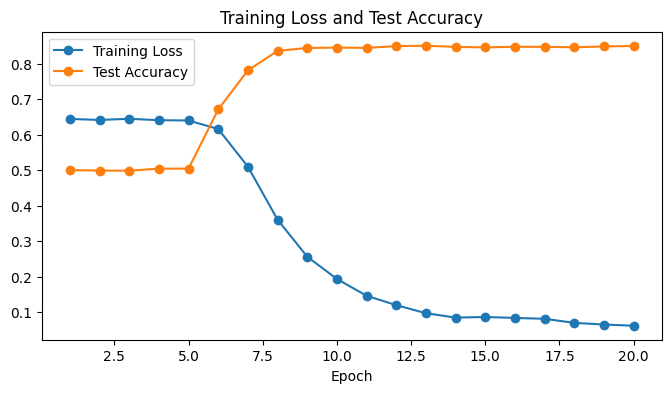

In [13]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs+1)
plt.figure(figsize=(8,4))
plt.plot(epochs, train_losses, '-o', label='Training Loss')
plt.plot(epochs, test_accuracies, '-o', label='Test Accuracy')
plt.title('Training Loss and Test Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [14]:
model.eval()  # 确保模型在评估模式
correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        outputs = model(X_batch)
        preds = (torch.sigmoid(outputs) >= 0.5).float()
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)
test_accuracy = correct / total
print(f"在测试集上的准确率: {test_accuracy:.4f}")


在测试集上的准确率: 0.8497
